Import the required modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import json
import csv

2024-02-15 17:25:52.198056: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 17:25:52.224704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_angles_from_folder(directory):
    imgdir = []
    with open(directory, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        for row in spamreader:
            conten_of_list = row[0]
            filenames = conten_of_list.split('\t')
            filenames = filenames[0]
            imgdir.append(filenames)
        return imgdir  

In [3]:
def load_images_from_folder(directory):
    images = []
    fileslist = os.listdir(directory)
    fileslist = sorted(fileslist , key = lambda fileslist: int(fileslist.split('.')[0]))
    #key=lambda x: int(x.split('_')[1]
    for filename in fileslist:
        #img = cv.imread(os.path.join(directory,filename))
        loc = os.path.join(directory,filename)
        img = tf.keras.preprocessing.image.load_img(loc, target_size=(300, 300), interpolation = 'nearest')
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        if img is not None:
            images.append(img)
    return np.asarray(images)

[9.81751893 1.02011143]


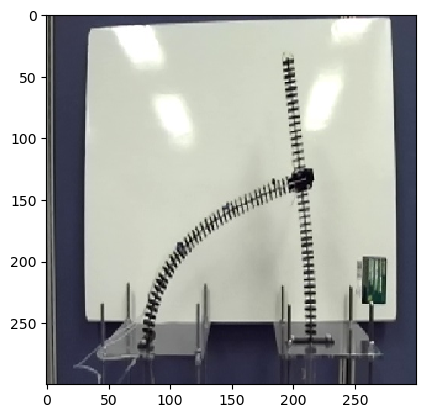

In [4]:
directory_imgs = './Codes_Developed_for_dataset_generation/dataset'
directory_angles = './Codes_Developed_for_dataset_generation/labels.csv'
imgs = load_images_from_folder(directory_imgs)
angles = np.genfromtxt(directory_angles, delimiter='\t'); angles = (angles[:,1:]) * (np.pi/180)
plt.imshow(imgs[240])
print(angles[240])

Defining the Convolutional Neural Network

In [5]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top = False, input_shape = (300,300,3))
base_model.trainable = False
X = base_model.layers[-5].output
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(2, 'linear', use_bias=True)(X)
model = tf.keras.Model(base_model.input, X)
opt = tf.keras.optimizers.Adam(learning_rate = 1e-6)
lossfunction = tf.keras.losses.MeanSquaredError()
model.summary()

2024-02-15 17:25:54.679651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 17:25:54.682708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 17:25:54.682807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

Compile the model

In [6]:
model.compile(optimizer = opt, loss = lossfunction, metrics = ['MeanAbsoluteError'])

Train and Save the model

In [7]:
history = model.fit(imgs[:900],angles[:900], batch_size = 16,epochs = 500)

Epoch 1/500


2024-02-15 17:25:56.253370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906


 1/57 [..............................] - ETA: 2:13 - loss: 79.8649 - mean_absolute_error: 8.0742

2024-02-15 17:25:58.210461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-15 17:25:58.226076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x808c4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 17:25:58.226089: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-15 17:25:58.228615: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 17:25:58.297385: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 8s 94ms/step - loss: 45.2853 - mean_absolute_error: 5.8290
Epoch 2/500
57/57 [==============================] - 5s 84ms/step - loss: 16.6357 - mean_absolute_error: 3.5990
Epoch 3/500
57/57 [==============================] - 5s 83ms/step - loss: 6.9596 - mean_absolute_error: 2.2249
Epoch 4/500
57/57 [==============================] - 5s 83ms/step - loss: 4.3019 - mean_absolute_error: 1.5884
Epoch 5/500
57/57 [==============================] - 5s 83ms/step - loss: 3.4714 - mean_absolute_error: 1.3966
Epoch 6/500
57/57 [==============================] - 5s 83ms/step - loss: 2.9548 - mean_absolute_error: 1.2810
Epoch 7/500
57/57 [==============================] - 5s 82ms/step - loss: 2.5840 - mean_absolute_error: 1.1933
Epoch 8/500
57/57 [==============================] - 5s 83ms/step - loss: 2.2868 - mean_absolute_error: 1.1197
Epoch 9/500
57/57 [==============================] - 5s 82ms/step - loss: 2.0305 - mean_absolute_error: 1.0553
Epoch 10/50

Save the model for test (Training takes time)

In [8]:
model.save('./TrainedCNNs_2dof/for_test', save_format = 'h5' )

/home/shayan/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Store the history of training in a json file

In [9]:
# Save the history to a JSON file
history_dict = history.history

# Specify the file path
file_path = './Training_History_Files/for_test.json'

# Convert the dictionary to a JSON string and save it to the file
with open(file_path, 'w') as json_file:
    json.dump(history_dict, json_file)

print(f"Training history saved to {file_path}")


Training history saved to ./Training_History_Files/for_test.json


Load the training results

In [10]:
file_path = './Training_History_Files/for_test.json'
history_dict = json.load(open(file_path, 'r'))

Plot the training curves

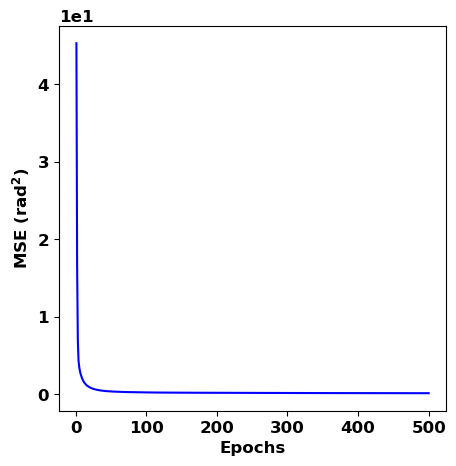

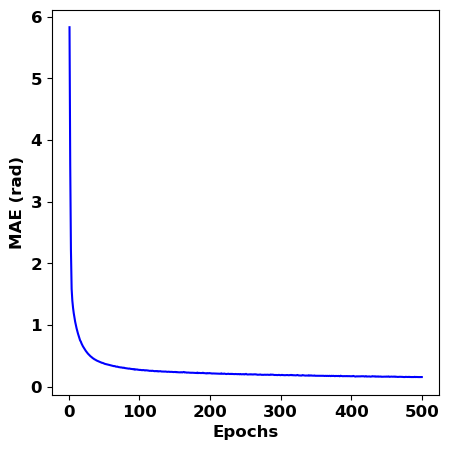

In [11]:
font = {'weight' : 'bold',
        'size'   : 12}
plt.rc ('font', **font)


figure1 = plt.figure(figsize=(5,5))
RootMeanSquareError =np.array(history_dict['loss'])
SampleNo = np.arange(1,len(RootMeanSquareError) + 1)



plt.plot(SampleNo,RootMeanSquareError , color = 'blue')
plt.xlabel('Epochs' , fontsize = 12 , weight='bold')
plt.ylabel(r'MSE (rad$^2$)' , fontsize = 12 , weight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('./Results_Paper/mse_for_test.eps', format='eps')
figure2 = plt.figure(figsize=(5,5))
MeanAbsError = history_dict['mean_absolute_error']


plt.plot(SampleNo,MeanAbsError , color = 'blue')
plt.xlabel('Epochs' , fontsize = 12 , weight='bold')
plt.ylabel('MAE (rad)' , fontsize = 12 , weight='bold')
plt.savefig('./Results_Paper/mae_for_test.eps', format='eps')